### **Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **import libraries**

In [ ]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense ,Dropout,Input,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K


random.seed(42)

### **Place tensors on the GPU**

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
tf.debugging.set_log_device_placement(True)
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
# Run on the GPU
c = tf.matmul(a, b)
print(c)

Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
tf.debugging.set_log_device_placement(True)
try:
  # Specify an invalid GPU device
  with tf.device('/device:GPU:2'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
except RuntimeError as e:
  print(e)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MatMul in device /job:localhost/replica:0/task:0/device:CPU:0


### **get video paths**

In [ ]:
video_Train_Fight_folder = '/content/drive/MyDrive/dataset/dataset-files/RWF-2000/train/Fight'
video_Train_NonFight_folder = '/content/drive/MyDrive/dataset/dataset-files/RWF-2000/train/NonFight'
video_Val_Fight_folder = '/content/drive/MyDrive/dataset/dataset-files/RWF-2000/val/Fight'
video_Val_NonFight_folder = '/content/drive/MyDrive/dataset/dataset-files/RWF-2000/val/NonFight'

### **Helper Functions**

In [ ]:
def load_Videos(path):
    list_of_video_paths = []
    video_files = [file for file in os.listdir(path) if file.endswith('.avi')]
    for video_file in video_files:
          video_path = os.path.join(path, video_file)
          list_of_video_paths.append(video_path)
    return list_of_video_paths

In [ ]:
def load_and_read_video_frames(video_path, num_frames, frame_height, frame_width,num_channels):
    cap = cv2.VideoCapture(video_path)
    frames = []
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (frame_width, frame_height))
        # gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        normalized_frame = frame / 255.0
        frames.append(normalized_frame)
    cap.release()
    frames = np.array(frames)
    return frames

In [ ]:
def shuffle_validation_data(video_paths, labels):
    permutation = np.random.permutation(len(video_paths))
    shuffled_video_paths = video_paths[permutation]
    shuffled_labels = labels[permutation]
    return shuffled_video_paths , shuffled_labels

In [ ]:
def load_batch(video_paths, batch_indices, num_frames, frame_height, frame_width,num_channels):
    batch_size = len(batch_indices)
    batch_data = np.zeros((batch_size, num_frames, frame_height, frame_width,num_channels))

    for i, sample_idx in enumerate(batch_indices):
        video_path = video_paths[sample_idx]
        video_frames = load_and_read_video_frames(video_path, num_frames, frame_height, frame_width,num_channels)
        batch_data[i] = video_frames
    return batch_data

### **Video data generator functions**

In [ ]:
# create a generator that yields batches of video data during the training of a neural network
def video_data_generator(video_paths, labels, batch_size, num_frames, frame_height, frame_width,num_channels):
    num_samples = len(video_paths)
    indices = np.arange(num_samples)
    def generator():
        while True:
            np.random.shuffle(indices)
            for i in range(0, num_samples, batch_size):
                batch_indices = indices[i:i + batch_size]
                batch_data = load_batch(video_paths, batch_indices, num_frames, frame_height, frame_width,num_channels)
                batch_labels = labels[batch_indices]
                yield batch_data, batch_labels
    return generator

In [ ]:
def prediction_data_generator(video_paths, batch_size, num_frames, frame_height, frame_width, num_channels):
    num_samples = len(video_paths)
    indices = np.arange(num_samples)
    def generator():
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i + batch_size]
            batch_data = load_batch(video_paths, batch_indices, num_frames, frame_height, frame_width, num_channels)
            yield batch_data
    return generator

### **load Train and Val videos**

In [ ]:
# get and load Train(Fight and NonFight) and Val(Fight and NonFight) video paths
Train_Fight_videos = load_Videos(video_Train_Fight_folder)
Train_NonFight_videos = load_Videos(video_Train_NonFight_folder)
Val_Fight_videos = load_Videos(video_Val_Fight_folder)
Val_NonFight_videos = load_Videos(video_Val_NonFight_folder)

### **combine fight and nonfight videos and create labels for them**

In [ ]:
# combine Fight and NonFight Train video paths
Train_videos = Train_Fight_videos[-400:] + Train_NonFight_videos[-400:]
# create labels for Fight[1] and NonFight[0] videos then combine them
Train_Fight_labels = [1] * len(Train_Fight_videos[-400:])
Train_NonFight_labels = [0] * len(Train_NonFight_videos[-400:])
Train_labels = Train_Fight_labels + Train_NonFight_labels

Train_videos = np.array(Train_videos)
labels =  np.array(Train_labels)
print(len(labels))
len(Train_videos)

800


800

In [ ]:
# combine Fight and NonFight Val video paths
Val_videos = Val_Fight_videos + Val_NonFight_videos
val_videos = np.array(Val_videos)
len(val_videos)

400

In [ ]:
# Actual labels for Fight[1] and NonFight[0] Val videos then combine them
Val_Fight_labels = [1] * len(Val_Fight_videos)
Val_NonFight_labels = [0] * len(Val_NonFight_videos)

Actual_Val_labels = Val_Fight_labels + Val_NonFight_labels
val_labels = np.array(Actual_Val_labels)
len(Actual_Val_labels)


400

In [ ]:
# test,actual_labels = shuffle_validation_data(val_videos,val_labels)
# len(test)

### **call video data generator function**

In [ ]:
Batch_Size = 6

In [ ]:
train_generator = video_data_generator(Train_videos,labels,Batch_Size,150,160,160,3)

In [ ]:
train_dataset = tf.data.Dataset.from_generator(
    generator=train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 160, 160, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)
train_dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=(None, 150, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### **Build and compile the Conv3dCNN model**

In [ ]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
  inputs = Input(shape=(150,160,160,3))
  #####################################################
  opt = inputs
  opt = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = BatchNormalization()(opt)
  opt = MaxPooling3D(pool_size=(1,2,2))(opt)

  opt = Conv3D(
      16, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = Conv3D(
      16, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = BatchNormalization()(opt)
  opt = MaxPooling3D(pool_size=(1,2,2))(opt)

  opt = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = BatchNormalization()(opt)
  opt = MaxPooling3D(pool_size=(1,2,2))(opt)

  opt = Conv3D(
      32, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = Conv3D(
      32, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(opt)
  opt = BatchNormalization()(opt)
  opt = MaxPooling3D(pool_size=(1,2,2))(opt)
  #####################################################
  x = MaxPooling3D(pool_size=(8,1,1))(opt)
  #####################################################
  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      64, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = Conv3D(
      64, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)

  x = Conv3D(
      128, kernel_size=(1,3,3), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = Conv3D(
      128, kernel_size=(3,1,1), strides=(1,1,1), kernel_initializer='he_normal', activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
  x = BatchNormalization()(x)
  x = MaxPooling3D(pool_size=(2,2,2))(x)
  #####################################################
  x = Flatten()(x)
  x = Dense(256,activation='relu')(x)
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  print(x)
  pred = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=pred)

  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='batch_normalization_8/batchnorm/add_1:0', description="created by layer 'batch_normalization_8'")
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 160, 160,    0         
                             3)]                                 
                                                                 
 conv3d (Conv3D)             (None, 150, 160, 160, 1   448       
                             6)                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 150, 160, 160, 1   784       
                             6)                                  
                                                                 
 batch_normalization (Batch  (None, 150, 160, 160, 1   64        
 Normali

### **Learning Rate Scheduler**

In [ ]:
def scheduler(epoch):
    if epoch % 10 == 0 and epoch != 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.7)
    return K.get_value(model.optimizer.lr)

reduce_lr = LearningRateScheduler(scheduler)

### **make checkpoint model**

In [ ]:
checkpoint_path = "/content/drive/MyDrive/dataset/dataset-files/3DCNN-weights/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
CP_callback = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

In [ ]:
os.listdir(checkpoint_dir)

['cp.ckpt.index', 'cp.ckpt.data-00000-of-00001', 'checkpoint']

### **train the model**

In [ ]:
steps_per_epoch = len(Train_videos) // Batch_Size
steps_per_epoch

133

In [ ]:
# model.fit(train_dataset,epochs=5, steps_per_epoch=steps_per_epoch, verbose=1,callbacks=[CP_callback,reduce_lr])

### **load weights and save model**

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
model.save('/content/drive/MyDrive/dataset/dataset-files/3DCNN-model')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op L2Loss in device /job:localh

### **make predictions**

In [ ]:
prediction_generator = prediction_data_generator(val_videos,1,150,160,160,3)

In [ ]:
predictions = []
for batch in prediction_generator():
  prediction = model.predict(batch)
  predictions.append(prediction.round())

predictions = np.array(predictions).reshape(-1, 1)


1/1 [==============================] - 0s 146ms/step


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd
# Saving the predictions to a CSV file
df = pd.DataFrame(predictions, columns=['Prediction'])
df.to_csv('/content/drive/MyDrive/dataset/dataset-files/predictions/predictions.csv', index=False)

In [ ]:
len(predictions)

400

### **Confusion Matrix**

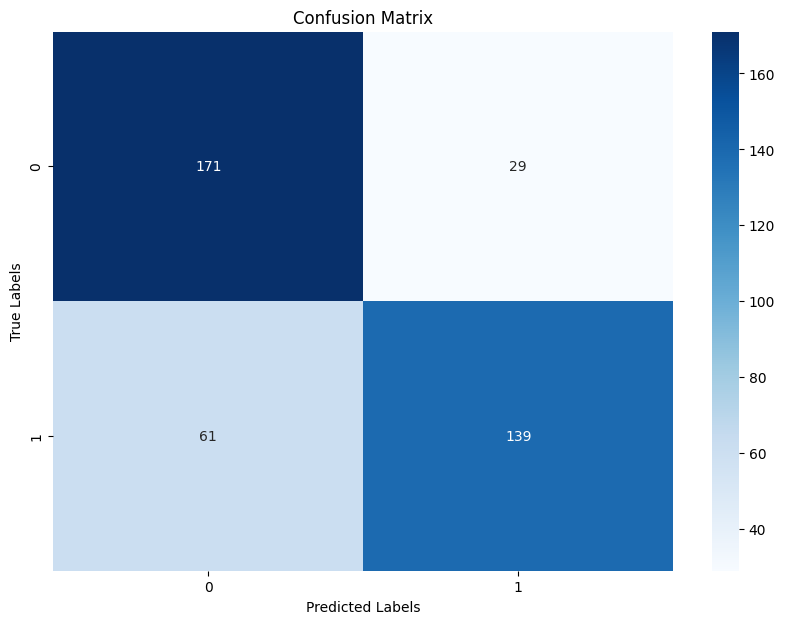

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# confusion matrix
test_cnf_matrix = confusion_matrix(val_labels,predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(test_cnf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **classification report**


In [ ]:
# 1 --> Violence
# 0 --> Non-violence
print("confusion matrix")
print(test_cnf_matrix)

print("Classification Report:")
print(classification_report(val_labels, predictions))

confusion matrix
[[171  29]
 [ 61 139]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       200
           1       0.83      0.69      0.76       200

    accuracy                           0.78       400
   macro avg       0.78      0.77      0.77       400
weighted avg       0.78      0.78      0.77       400

